#Pildituvastus ja Tehisnärvivõrgud

Üks masinõppe olulisemaid alaliike on “sügavõpe”, mis kasutab mudelitena tehisnärvivõrke. Tehisnärvivõrkudel põhinevatel mudelitel on palju rakendusi mitmesugustest tööstusharudes, robootikas jne. 

<img src="https://drive.google.com/uc?export=download&id=1II40sa-pTzMLjA2flZLpYQD_PPqLA4np" width="500px" style="display:inline-block"/>

<img src="https://drive.google.com/uc?export=download&id=1tyTA5Qrfo4G2eCA4D8VS-C0Rt_QAA9Td" width="500px" style="display:inline-block"/>

## Konvolutsioonilised närvivõrgud
Konvolutsioonilised närvivõrgud on üks tüüp tehisnärvivõrke, mis sobivad hästi piltide analüüsimisel, klassifitseerimisel, segmenteerimisel jne. Konvolutsioonilised närvivõrgud võtavad arvesse sisendväärtuste omavahelist järjestust ja paigutust. Selle närvivõrgu töö käigus rakendatakse sisenditele “filtreid”, mille tulemusel tekivad tunnuskaartid. Tunnuskaartid väljendavad erinevaid kujundeid, mis antud pilte võiks iseloomustada. Uue sisendi korral sõltub klassifitseerimise tulemus sellest, kuivõrd sisendpildi mingid piirkonnad “aktiveeruvad” antud tunnuskaartidega. Konvolutsioonilisi kihte on sellises närvivõrgud harilikult mitu, ning sügavamates kihtides tekivad tunnuskaartid sisaldavad üha terviklikemaid ja keerulisemaid kujundeid. 

<img src="https://drive.google.com/uc?export=download&id=1RRU5LdfxepoZDfT-WppyDAW08cq_JsT5" />


### Mida saab pildituvastusega teha?

1) Tootmisdetailide (üldiselt mistahes objektide) klassifitseerimine </br>
2) Tootmisdefektide tuvastamine, mis on üldiselt sama, mis objekti tuvastamine, aga objektid jaotatakse kahte erinevasse klassi: katkised objektid ja terved objektid </br>
3) Sümbolite, märgendite ja teksti tuvastamine </br>
4) Näotuvastus </br>
5) Objektide (nt tootmisdetailide) automaatne loendamine

##1. Äriliste eesmärkide seadmine

Metallistööstusettevõtte ühes tootmisüksuses valatakse metallvorme. Aeg-ajalt on valatud ja maha jahtunud metallist detail defekte: detail võib olla praguline, äärest murdunud või purunenud jne. 

Esimese lahendusena on ettevõte palganud kvaliteedikontrollijaid, kes vaatavad käsitsi metallvorme üle ning eemaldavad defektsed detailid.

##2. Andmete mõistmine

Ettevõte otsustab, et tuleks luua automaatne lahendus, mis pildituvastuse abil otsustab, kas antud detail on defektne või mitte. Tehisnärvivõrkudel põhineva pildituvastuse jaoks on vaja suurt hulka märgendatud andmeid, s.t palju pilte sellest detailist erinevates seisukordades, nii katkiseid kui ka terveid detaile. Samast detailist võib teha mitu pilti erinevates asendites. Et andmete annoteerimist ei peaks liiga kaua ootama, uuritakse välja, kas leidub juba olemasolevaid defektseid detaile, mis kuskil on ladustatud. Lisaks leidub laos veel terveid detaile. Nendest kõikidest tehakse erinevates asendites pilte ning katkiste detailide pildid lisatakse kausta "katkised" ning terved detailid lisatakse kausta "terved".

##3. Andmete ettevalmistamine

In [2]:
#Laeme sisse mõningaid vajalikke kooditeeke

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Pakime metallvalamute pildid lahti
!unzip drive/MyDrive/Colab\ Notebooks/Tööstus/Andmed/metallvalamud.zip

Streaming output truncated to the last 5000 lines.
  inflating: metallvalamud/katkised/cast_def_0_5850.jpeg  
  inflating: metallvalamud/katkised/cast_def_0_5857.jpeg  
  inflating: metallvalamud/katkised/cast_def_0_5858.jpeg  
  inflating: metallvalamud/katkised/cast_def_0_5859.jpeg  
  inflating: metallvalamud/katkised/cast_def_0_586.jpeg  
  inflating: metallvalamud/katkised/cast_def_0_5861.jpeg  
  inflating: metallvalamud/katkised/cast_def_0_5864.jpeg  
  inflating: metallvalamud/katkised/cast_def_0_5865.jpeg  
  inflating: metallvalamud/katkised/cast_def_0_5867.jpeg  
  inflating: metallvalamud/katkised/cast_def_0_5868.jpeg  
  inflating: metallvalamud/katkised/cast_def_0_5872.jpeg  
  inflating: metallvalamud/katkised/cast_def_0_5877.jpeg  
  inflating: metallvalamud/katkised/cast_def_0_588.jpeg  
  inflating: metallvalamud/katkised/cast_def_0_5881.jpeg  
  inflating: metallvalamud/katkised/cast_def_0_5883.jpeg  
  inflating: metallvalamud/katkised/cast_def_0_5887.jpeg  
  infla

In [ ]:
#Loome funktsiooni, mis võimaldab meil mugavalt etteantud kaustast kõiki pilte sisse laadida 
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            img=cv2.resize(img,(100,100))
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            images.append(img)
    return images

#Kasutame eeldefineeritud funktsiooni, et lugeda eraldi muutujatesse sisse kõik pildid tervetest detailidest ja katkistest detailidest
terved = load_images_from_folder("metallvalamud/terved")
katkised = load_images_from_folder("metallvalamud/katkised")

In [ ]:
terved = np.array(terved)
katkised = np.array(katkised)

In [ ]:
#Loome 2 siltide järjendit. Tähistame terveid detaile arvuga 0 ning katkiseid detaile arvuga 1.
labels_terved = np.empty(len(terved), dtype="int")
labels_terved[:] = 0
labels_katkised = np.empty(len(katkised), dtype="int")
labels_katkised[:] = 1

In [ ]:
#Lisame pildid ja nende piltide seotud märgendid kokku ühte järjendisse
metallvormid = np.concatenate((terved, katkised))
margendid = np.concatenate((labels_terved, labels_katkised))

NameError: ignored

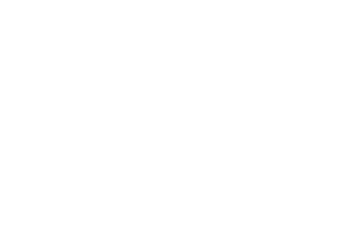

In [1]:
import matplotlib.pyplot as plt 

#Vaatame mõnda näidet tervest detailist
plt.axis('off')
plt.imshow(terved[100])

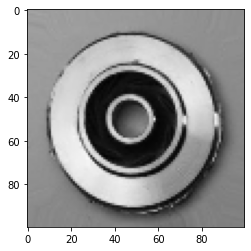

In [ ]:
#Vaatame ühte näidet katkisest detailist
plt.imshow(katkised[100])

In [ ]:
from sklearn.model_selection import train_test_split

#train_test_split jagab esialgsed pildid ja märgendid mõlemad omakorda treenimis- ja testhulkadeks. Treenimishulkasid kasutame mudeli treenimiseks, ning testhulkasid kasutame mudeli headuse hindamiseks pärast treenimist.
X_train, X_test, y_train, y_test = train_test_split(metallvormid, margendid, test_size=0.33, random_state=42)

In [ ]:
X_train.shape

(4826, 100, 100, 3)

##4. Mudeldamine

###4.1 Mudeli valimine
Tehisnärvivõrgu struktuuri valimine ja loomine on omaette kunst.

In [ ]:
#importing required libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img ,img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report,confusion_matrix
#Creating model

image_shape = (100,100,3)
batch_size = 32 #according your model and your choice

model = Sequential()

model.add(Conv2D(filters=8, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=16, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=16, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))




model.add(Flatten())

model.add(Dense(224))
model.add(Activation('relu'))

# Last layer
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss',patience=2)

###4.2 Mudeli treenimine

Mudeli treenimine tehisnärvivõrkudes tähendab seda, et närvivõrgule antakse sisendiks blokkide kaupa pilte, mis on arvulisteks väärtusteks muudetud. Need arvud liiguvad läbi närvivõrgu kihtide ning viimasel kihil on 2 arvu, mis näitavad, kui tõenäoliselt mudeli arvates antud pilt katkiseks või terveks klassifitseerub. Seda ennustust võrreldakse aga tegeliku märgendiga, ning vea korral korrigeeritakse vähe haaval närvivõrgu parameetreid, et järgmisel korral ennustusviga oleks väiksem.

In [ ]:
results = model.fit(X_train, y_train, epochs=3, validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/3
151/151 [==============================] - 29s 189ms/step - loss: 7.8130 - accuracy: 0.6848 - val_loss: 0.4089 - val_accuracy: 0.8175
Epoch 2/3
151/151 [==============================] - 29s 189ms/step - loss: 0.3330 - accuracy: 0.8523 - val_loss: 0.3063 - val_accuracy: 0.8768
Epoch 3/3
151/151 [==============================] - 29s 195ms/step - loss: 0.2147 - accuracy: 0.9123 - val_loss: 0.2703 - val_accuracy: 0.8844


###4.3 Mudeli headuse hindamine

Pärast närvivõrgu (mudeli) treenimist (loomist) tuleb hinnata, kui täpne antud mudel on uute, veel enne nägemata piltide klassifitseerimisel. 

In [ ]:
#predict() funktsioon võtab sisendiks testhulga piltidest ning hindab igaühe puhul neist, kui tõenäoliseks ta peab, et antud pilt on katkine. Tõenäosus on arv 0 ja 1 vahel.
pred_probability = model.predict(X_test)

In [ ]:
#Määrame ennustuse 1-ks (katkine), kui mudel hindab detaili katkiseks olemise rohkem kui 0.5 tõenäosusega.
predictions = pred_probability > 0.5

In [ ]:
#predictions väärtuse me hakkame võrdlema tegelike teadaolevate märgendite y_test väärtustega. 
y_test

array([1, 0, 1, ..., 0, 0, 1])

In [ ]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.83      0.93      0.87      1034
           1       0.94      0.85      0.89      1344

    accuracy                           0.88      2378
   macro avg       0.88      0.89      0.88      2378
weighted avg       0.89      0.88      0.88      2378



In [ ]:
model.save('inspection_of_casting_products.h5')

##5. Projekti tulemuste hindamine

##6. Kasutusele võtmine ehk juurutamine

Nüüd, kui meil on olemas arvutiprogramm, mis tuvastab, kas kaamerapildil olev detail on defekte või mitte, pole kogu lahendus sellega veel tehtud. Nüüd on vaja otsustada, kuidas saadud programm integreerida muude süsteemidega, mis antud detailiga kas reaalselt ja füüsiliselt saab midagi ette võtta, nt tervetest detailidest eemale suunata jne. Võimalikke lahendusviise on palju, ja nõuavad ilmselt robootikat.

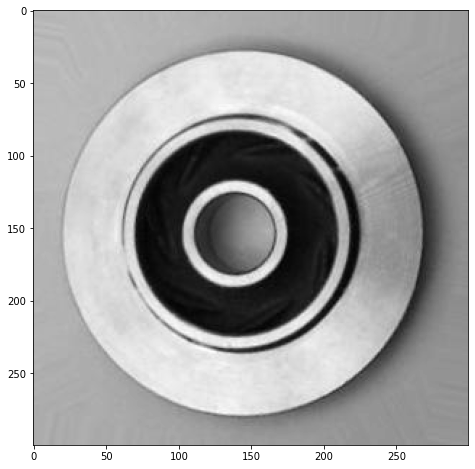

In [ ]:
img = cv2.imread(test_path+'ok_front/cast_ok_0_1020.jpeg',0)
img = img/255 #rescalinng
pred_img =img.copy()

plt.figure(figsize=(12,8))
plt.imshow(img,cmap='gray')

ok_front


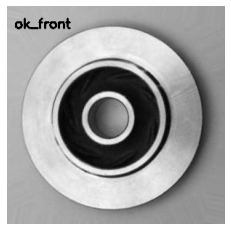

In [ ]:
prediction = model.predict(img.reshape(-1,300,300,1))
if (prediction<0.5):
    print("def_front")
    cv2.putText(pred_img, "def_front", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
else:
    print("ok_front")
    cv2.putText(pred_img, "ok_front", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    
plt.imshow(pred_img,cmap='gray')
plt.axis('off')
plt.show()

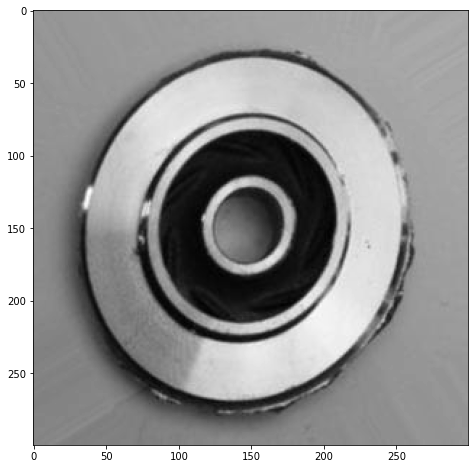

In [ ]:
img1 = cv2.imread(test_path+'def_front/cast_def_0_1134.jpeg',0)
img1 = img1/255
pred_img1 =img1.copy()

plt.figure(figsize=(12,8))
plt.imshow(img1,cmap='gray')

def_front


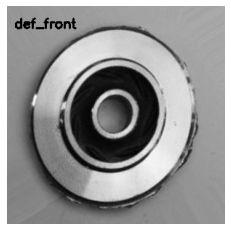

In [ ]:
prediction = model.predict(img1.reshape(-1,300,300,1))
if (prediction<0.5):
    print("def_front")
    cv2.putText(pred_img1, "def_front", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
else:
    print("ok_front")
    cv2.putText(pred_img1, "ok_front", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    
plt.imshow(pred_img1,cmap='gray')
plt.axis('off')
plt.show()

#SINU KORD

In [ ]:
!wget https://www.dropbox.com/s/47od3by2b2vgk22/apples.zip?dl=0
!unzip apples.zip\?dl\=0

Streaming output truncated to the last 5000 lines.
  inflating: apples/train/rottenapples/rotated_by_75_Screen Shot 2018-06-07 at 3.00.56 PM.png  
  inflating: apples/train/rottenapples/rotated_by_75_Screen Shot 2018-06-07 at 3.01.09 PM.png  
  inflating: apples/train/rottenapples/rotated_by_75_Screen Shot 2018-06-07 at 3.01.21 PM.png  
  inflating: apples/train/rottenapples/rotated_by_75_Screen Shot 2018-06-07 at 3.01.38 PM.png  
  inflating: apples/train/rottenapples/rotated_by_75_Screen Shot 2018-06-07 at 3.01.54 PM.png  
  inflating: apples/train/rottenapples/rotated_by_75_Screen Shot 2018-06-07 at 3.02.02 PM.png  
  inflating: apples/train/rottenapples/rotated_by_75_Screen Shot 2018-06-07 at 3.02.18 PM.png  
  inflating: apples/train/rottenapples/rotated_by_75_Screen Shot 2018-06-07 at 3.02.37 PM.png  
  inflating: apples/train/rottenapples/rotated_by_75_Screen Shot 2018-06-07 at 3.02.51 PM.png  
  inflating: apples/train/rottenapples/rotated_by_75_Screen Shot 2018-06-07 at 3.03.0

In [ ]:
#Lae kasutades funktsiooni load_images_from_folder() sisse pildid mädanenud õuntest ning pildid tervetes õuntest

In [ ]:
#Kuna mõningaid pilte nii tervetes kui ka mädadenud õuntest

In [ ]:
#Moodusta tervete ja mädanenud õunte jaoks märgendite järjendid

In [ ]:
#Pane omavahel kokku (samasse järjendisse) terved ja mädadenud õunte piltide järjendid ning lisaks pane oma vahel kokku (samasse järjendisse) tervete ja mädanenud õunte märgendid

In [ ]:
#Jaga piltide ja märgendite järjendid treenimis- ja testimishulkades kasutades funktsiooni train_test_split(...)

In [ ]:
#Mudelina kasutame samat närvivõrku, mis on juba mälusse sisse loetud (kui oled eelmisi koodiblokke edaukalt käivitanud), kuid treeni seda mudelit nüüd
#uutel (õunte) piltidel (kasutades model.fit(...))

In [ ]:
#Salvesta loodud mudeli ennustused testimishulga piltidel

In [ ]:
#Kuva mudeli ennustustulemused, kasutades funktsiooni classification_report(...)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "drive/MyDrive/Colab Notebooks/Tööstus/Andmed/garbage"

Streaming output truncated to the last 5000 lines.
  inflating: Garbage classification/Garbage classification/cardboard/cardboard152.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard153.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard154.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard155.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard156.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard157.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard158.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard159.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard16.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard160.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/c

In [ ]:
#Loome funktsiooni, mis võimaldab meil mugavalt etteantud kaustast kõiki pilte sisse laadida 
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            img=cv2.resize(img,(200,200))
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            images.append(img)
    return images

#Kasutame eeldefineeritud funktsiooni, et lugeda eraldi muutujatesse sisse kõik pildid tervetest detailidest ja katkistest detailidest
plastic = load_images_from_folder("garbageclassification/Garbage classification/plastic")
metal = load_images_from_folder("garbageclassification/Garbage classification/metal")
paper = load_images_from_folder("garbageclassification/Garbage classification/paper")

In [ ]:
plastic = np.array(plastic)
metal = np.array(metal)
paper = np.array(paper)

In [ ]:
labels_plastic = np.empty(len(plastic), dtype="object")
labels_plastic[:] = "plastik"
labels_metal = np.empty(len(metal), dtype="object")
labels_metal[:] = "metall"
labels_paper = np.empty(len(paper), dtype="object")
labels_paper[:] = "paber"

In [ ]:
from sklearn.preprocessing import OneHotEncoder

materials = np.concatenate((plastic, metal, paper))
margendid = np.concatenate((labels_plastic, labels_metal, labels_paper))

onehot_encoder = OneHotEncoder(sparse=False)
margendid = onehot_encoder.fit_transform(margendid.reshape(-1,1))

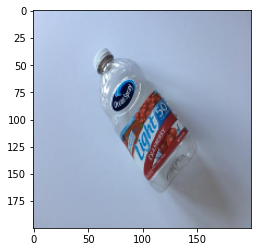

In [ ]:
import matplotlib.pyplot as plt 

#Vaatame mõnda näidet tervest detailist
plt.imshow(plastic[100])

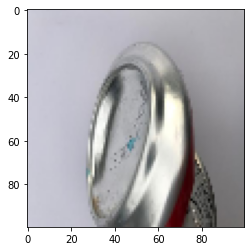

In [ ]:
#Vaatame ühte näidet katkisest detailist
plt.imshow(metal[100])

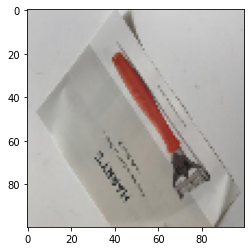

In [ ]:

plt.imshow(paper[100])

In [ ]:
from sklearn.model_selection import train_test_split

#train_test_split jagab esialgsed pildid ja märgendid mõlemad omakorda treenimis- ja testhulkadeks. Treenimishulkasid kasutame mudeli treenimiseks, ning testhulkasid kasutame mudeli headuse hindamiseks pärast treenimist.
X_train, X_test, y_train, y_test = train_test_split(materials, margendid, test_size=0.33, random_state=42)

In [ ]:
#importing required libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img ,img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report,confusion_matrix
#Creating model

image_shape = (200,200,3)
batch_size = 32 #according your model and your choice

model = Sequential()

model.add(Conv2D(filters=8, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=16, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=16, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(224))
model.add(Activation('relu'))

# Last layer
model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
#early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
#results = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[early_stop])
results = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
32/32 [==============================] - 24s 723ms/step - loss: 27.5853 - accuracy: 0.3668 - val_loss: 1.0819 - val_accuracy: 0.4318
Epoch 2/30
32/32 [==============================] - 24s 767ms/step - loss: 0.9133 - accuracy: 0.5809 - val_loss: 1.1228 - val_accuracy: 0.4257
Epoch 3/30
32/32 [==============================] - 23s 716ms/step - loss: 0.6252 - accuracy: 0.7367 - val_loss: 1.1863 - val_accuracy: 0.4460
Epoch 4/30
32/32 [==============================] - 23s 720ms/step - loss: 0.4408 - accuracy: 0.8161 - val_loss: 1.5905 - val_accuracy: 0.4603
Epoch 5/30
32/32 [==============================] - 23s 722ms/step - loss: 0.2995 - accuracy: 0.8754 - val_loss: 1.9529 - val_accuracy: 0.4827
Epoch 6/30
32/32 [==============================] - 23s 722ms/step - loss: 0.2273 - accuracy: 0.8925 - val_loss: 2.3835 - val_accuracy: 0.4868
Epoch 7/30
32/32 [==============================] - 23s 718ms/step - loss: 0.2551 - accuracy: 0.9055 - val_loss: 2.1974 - val_accuracy: 0.439